In [1]:
import pandas as pd
import glob
import os


In [2]:

from pyspark.sql import SparkSession

# Set environment variables
os.environ['JAVA_HOME'] = '/home/ymusic7/.conda/envs/myenv'
os.environ['PYSPARK_PYTHON'] = '/home/ymusic7/.conda/envs/myenv/bin/python'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/ymusic7/.conda/envs/myenv/bin/python'

# Initialize Spark session with correct Python paths
#spark = SparkSession.builder \
    #.appName("restaurant_cluster_analysis") \
    #.config("spark.pyspark.python", "/home/ymusic7/.conda/envs/myenv/bin/python") \
    #.config("spark.pyspark.driver.python", "/home/ymusic7/.conda/envs/myenv/bin/python") \
    #.getOrCreate()


# Increase memory allocation
from pyspark.sql import SparkSession



# Initialize Spark session with  increased memory allocation
spark = SparkSession.builder \
    .appName("restaurant_cluster_analysis") \
    .config("spark.pyspark.python", "/home/ymusic7/.conda/envs/myenv/bin/python") \
    .config("spark.pyspark.driver.python", "/home/ymusic7/.conda/envs/myenv/bin/python") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Check if the Spark session is running
print(spark.version)



spark.sparkContext.setLogLevel("ERROR")  # Suppress detailed logs



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/20 10:07:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


3.5.3


In [3]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

schema = StructType([
    StructField("name", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lon", DoubleType(), True),
    StructField("text", StringType(), True),
    StructField("date", StringType(), True),
    StructField("score", IntegerType(), True),
    StructField("keyword", StringType(), True),
    StructField("addr", StringType(), True),
    StructField("language", StringType(), True)
])

df = spark.read.csv('/home/ymusic7/metro_restaurants/combined.csv', header=False, schema=schema)


In [4]:
from pyspark.sql import functions as F
df_english = df.filter(F.col('language') == 'en')
df_english.show(5)


+--------------------+----------+------------------+--------------------+-------------------+-----+-------------------+--------------------+--------+
|                name|       lat|               lon|                text|               date|score|            keyword|                addr|language|
+--------------------+----------+------------------+--------------------+-------------------+-----+-------------------+--------------------+--------+
|           Koi Sushi|44.6048264|       -79.3724546|I've been here se...|2021-01-29 23:56:06|    5|japanese restaurant|660 Atherley Rd #...|      en|
|           Koi Sushi|44.6048264|       -79.3724546|Koi sushi has bee...|2024-05-27 00:55:48|    5|japanese restaurant|660 Atherley Rd #...|      en|
|Hanabi Japanese R...| 44.583675|       -79.8655205|Very cute little ...|2024-09-13 11:21:05|    5|japanese restaurant|5 Queen St E, Elm...|      en|
|           2go sushi|44.6069384|       -80.5923143|Cozy restaurant w...|2024-09-03 12:24:22|    5|j

In [5]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import pyspark.sql.functions as F

# Convert text to lowercase
df_cleaned = df_english.withColumn('text', F.lower(F.col('text')))

# Tokenize the text
tokenizer = Tokenizer(inputCol='text', outputCol='words')
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stopwords
stopwords = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words', stopWords=stopwords)
df_filtered = remover.transform(df_tokenized)

# View the cleaned and tokenized text
df_filtered.select('filtered_words').show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                                                                                                                                                                                                                                      |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[several, times, n

In [6]:
from pyspark.ml.feature import CountVectorizer

# Using Bag-of-Words model
vectorizer = CountVectorizer(inputCol='filtered_words', outputCol='features')
vectorized_model = vectorizer.fit(df_filtered)
df_bow = vectorized_model.transform(df_filtered)

# View the Bag-of-Words features
df_bow.select('features').show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
from pyspark.ml.feature import HashingTF, IDF

# Generate term frequency vectors
hashingTF = HashingTF(inputCol='filtered_words', outputCol='raw_features', numFeatures=5000)
df_tf = hashingTF.transform(df_filtered)

# Apply IDF to scale term frequency vectors
idf = IDF(inputCol='raw_features', outputCol='features')
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

# View the TF-IDF features
df_tfidf.select('features').show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features        

In [ ]:
from pyspark.ml.clustering import KMeans

# Define K-Means model
kmeans = KMeans(featuresCol='features', predictionCol='cluster', k=6, seed=42)
model = kmeans.fit(df_tfidf)

# Assign clusters to reviews
df_clusters = model.transform(df_tfidf)

# View clustered data
df_clusters.select('text', 'cluster').show(5, truncate=False)


In [ ]:
df_clusters.printSchema()


In [ ]:
df_clusters.select('keyword').distinct().show()



In [18]:
df_japanese = df_clusters.filter(F.col('keyword') == 'japanese restaurant')
df_chinese = df_clusters.filter(F.col('keyword') == 'chinese restaurant')



In [28]:
# Define sentiment for Japanese reviews
df_japanese = df_japanese.withColumn(
    "sentiment",
    when(F.col("score") <= 2, "negative")
    .when(F.col("score") == 3, "neutral")
    .when(F.col("score") >= 4, "positive")
)

# Define sentiment for Chinese reviews
df_chinese = df_chinese.withColumn(
    "sentiment",
    when(F.col("score") <= 2, "negative")
    .when(F.col("score") == 3, "neutral")
    .when(F.col("score") >= 4, "positive")
)



In [29]:
# Group by cluster and sentiment for Japanese reviews
japanese_sentiment_distribution = df_japanese.groupBy("cluster", "sentiment").count()

# Group by cluster and sentiment for Chinese reviews
chinese_sentiment_distribution = df_chinese.groupBy("cluster", "sentiment").count()



In [30]:
# Convert to Pandas
japanese_sentiment_df = japanese_sentiment_distribution.toPandas()
chinese_sentiment_df = chinese_sentiment_distribution.toPandas()



In [7]:
import seaborn as sns
print(sns.__version__)



0.13.2


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


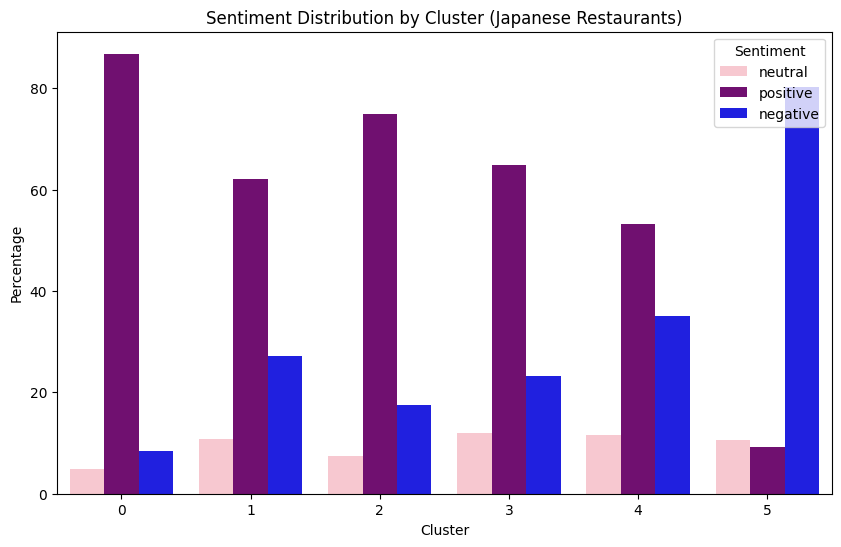

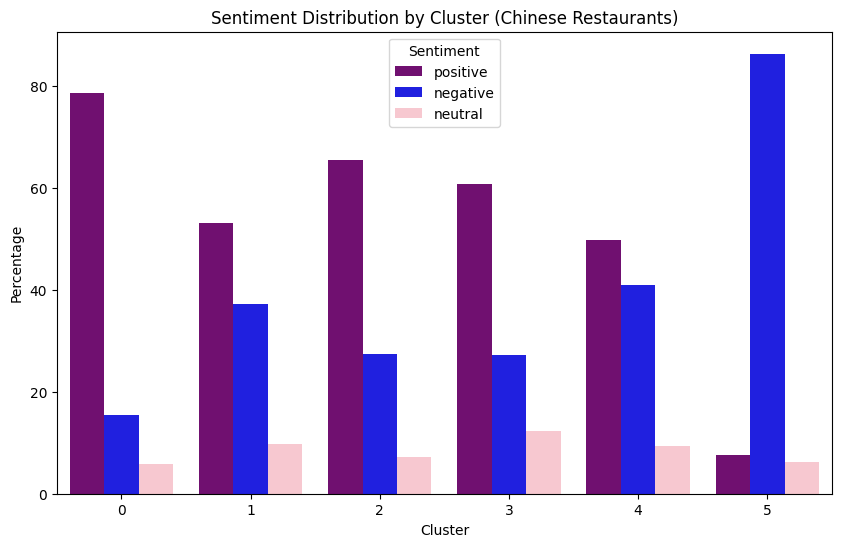

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrames to Pandas for Japanese and Chinese reviews
japanese_sentiment_df = df_japanese.groupBy("cluster", "sentiment").count().toPandas()
chinese_sentiment_df = df_chinese.groupBy("cluster", "sentiment").count().toPandas()

# Add a total column for percentage calculation
japanese_total = japanese_sentiment_df.groupby("cluster")["count"].sum().reset_index()
japanese_total.rename(columns={"count": "total"}, inplace=True)
japanese_sentiment_df = japanese_sentiment_df.merge(japanese_total, on="cluster")
japanese_sentiment_df["percentage"] = (japanese_sentiment_df["count"] / japanese_sentiment_df["total"]) * 100

chinese_total = chinese_sentiment_df.groupby("cluster")["count"].sum().reset_index()
chinese_total.rename(columns={"count": "total"}, inplace=True)
chinese_sentiment_df = chinese_sentiment_df.merge(chinese_total, on="cluster")
chinese_sentiment_df["percentage"] = (chinese_sentiment_df["count"] / chinese_sentiment_df["total"]) * 100

# Ensure consistent colors for sentiment categories
color_map = {"positive": "purple", "neutral": "pink", "negative": "blue"}

# Plot for Japanese restaurants
plt.figure(figsize=(10, 6))
sns.barplot(
    data=japanese_sentiment_df,
    x="cluster",
    y="percentage",
    hue="sentiment",
    palette=color_map
)
plt.title("Sentiment Distribution by Cluster (Japanese Restaurants)")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.legend(title="Sentiment")
plt.show()

# Plot for Chinese restaurants
plt.figure(figsize=(10, 6))
sns.barplot(
    data=chinese_sentiment_df,
    x="cluster",
    y="percentage",
    hue="sentiment",
    palette=color_map
)
plt.title("Sentiment Distribution by Cluster (Chinese Restaurants)")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.legend(title="Sentiment")
plt.show()



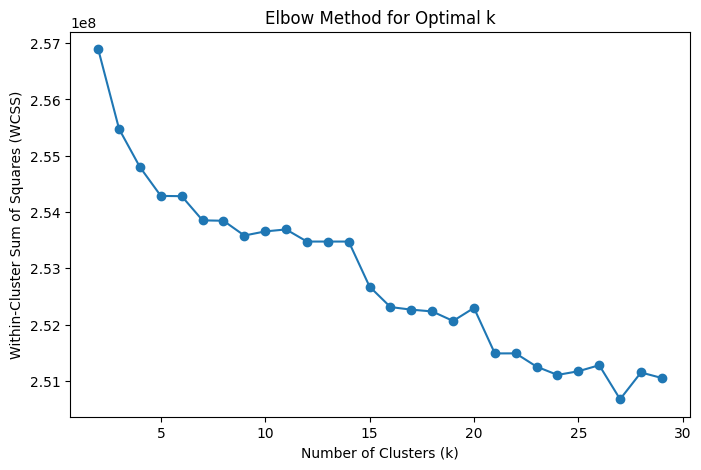

In [11]:
# k= 6 may not be suitable for this amount of reviews, using elbow method to find a better k value
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

wcss = []
for k in range(2, 30):  # Try different k values
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_tfidf)
    wcss.append(model.summary.trainingCost)

# Plot WCSS to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(range(2, 30), wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.show()


In [ ]:
#when i do the clustering training, should i separate Chinese and Japanese restaruant after tf idf 
#do cluserting separately or together cuz i think i did together and then seperate
#co-word?
# clustering based on TF-IDF, similar types of linguistic framing or similar consumer perceptions (e.g., clusters that reflect affordability, quality of service, etc.).


In [11]:
# Separate datasets for Chinese and Japanese restaurants
df_chinese = df_tfidf.filter(F.col('keyword') == 'chinese restaurant')
df_japanese = df_tfidf.filter(F.col('keyword') == 'japanese restaurant')

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Run clustering for Chinese restaurants
kmeans_chinese = KMeans(featuresCol="features", k=12, seed=42)
model_chinese = kmeans_chinese.fit(df_chinese)
df_chinese_clusters = model_chinese.transform(df_chinese)

# Run clustering for Japanese restaurants
kmeans_japanese = KMeans(featuresCol="features", k=12, seed=42)
model_japanese = kmeans_japanese.fit(df_japanese)
df_japanese_clusters = model_japanese.transform(df_japanese)



In [34]:
# Count the number of reviews in each cluster for Chinese restaurants
df_chinese_clusters.groupBy("prediction").count().show()

# Count the number of reviews in each cluster for Japanese restaurants
df_japanese_clusters.groupBy("prediction").count().show()


+----------+------+
|prediction| count|
+----------+------+
|         1|  2851|
|         6|     1|
|         3| 50606|
|         5| 20305|
|         4|  8637|
|        11|  3871|
|         2| 17984|
|         0|164571|
|         9|     1|
|         8|     4|
|         7|     1|
|        10|     1|
+----------+------+



+----------+------+
|prediction| count|
+----------+------+
|         1|126729|
|         3|  6718|
|         5|  1799|
|         4| 22643|
|        10|  1932|
|        11|  4247|
|         2| 15386|
|         0| 31764|
|         6|     1|
|         9|     4|
|         8|     1|
|         7|     2|
+----------+------+



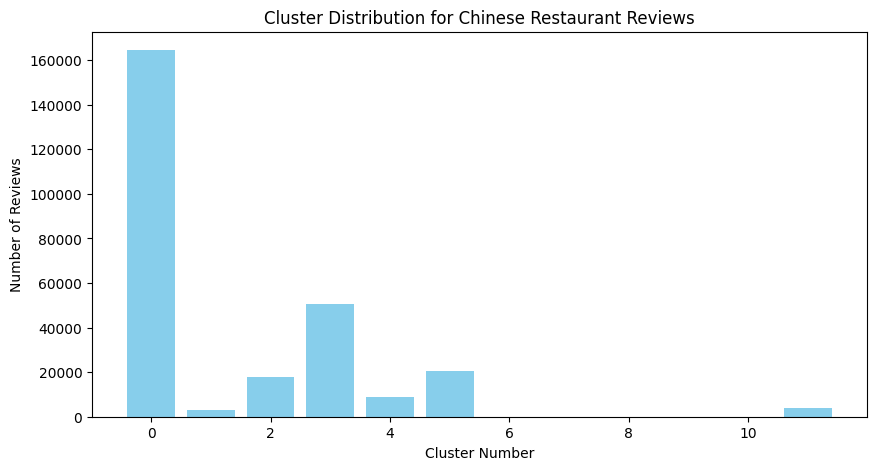

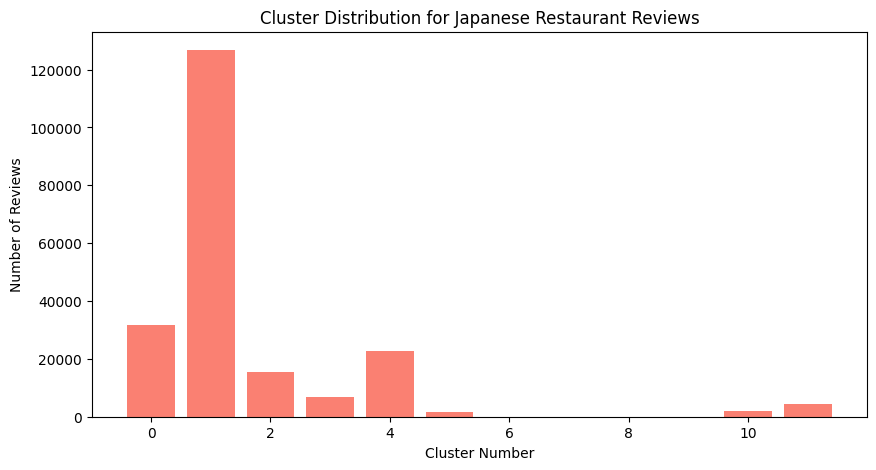

In [35]:
#visualize
import pandas as pd
import matplotlib.pyplot as plt

# Get cluster count data for Chinese restaurants
chinese_cluster_counts = df_chinese_clusters.groupBy("prediction").count().collect()
chinese_clusters_df = pd.DataFrame(chinese_cluster_counts, columns=["cluster", "count"])

# Plot the cluster distribution for Chinese restaurants
plt.figure(figsize=(10, 5))
plt.bar(chinese_clusters_df["cluster"], chinese_clusters_df["count"], color='skyblue')
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.title("Cluster Distribution for Chinese Restaurant Reviews")
plt.show()

# Get cluster count data for Japanese restaurants
japanese_cluster_counts = df_japanese_clusters.groupBy("prediction").count().collect()
japanese_clusters_df = pd.DataFrame(japanese_cluster_counts, columns=["cluster", "count"])

# Plot the cluster distribution for Japanese restaurants
plt.figure(figsize=(10, 5))
plt.bar(japanese_clusters_df["cluster"], japanese_clusters_df["count"], color='salmon')
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.title("Cluster Distribution for Japanese Restaurant Reviews")
plt.show()


In [18]:
#LDA
# how consumer reviews reflect cultural contexts and how linguistic framing
# Import necessary modules for LDA
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import functions as F

# Load data and filter by cuisines (already clustered into 12 clusters)
df_chinese_clusters = df_chinese_clusters.select('prediction', 'filtered_words')
df_japanese_clusters = df_japanese_clusters.select('prediction', 'filtered_words')

# Combine the clusters into a single DataFrame with a 'cuisine' column for differentiation
df_combined = df_chinese_clusters.withColumn('cuisine', F.lit('chinese'))
df_combined = df_combined.union(df_japanese_clusters.withColumn('cuisine', F.lit('japanese')))

# Prepare the data for LDA
# Convert filtered words into array<string> to be processed by CountVectorizer
df_combined = df_combined.withColumn('filtered_words_array', F.col('filtered_words'))

# Use CountVectorizer to convert the text data into a format suitable for LDA
vectorizer = CountVectorizer(inputCol='filtered_words_array', outputCol='features')
vectorizer_model = vectorizer.fit(df_combined)
df_combined_vectorized = vectorizer_model.transform(df_combined)

# Run LDA on the combined dataset to discover topics in the clusters
lda = LDA(k=12, maxIter=50, featuresCol='features', seed=42)
lda_model = lda.fit(df_combined_vectorized)

# Describe topics extracted by LDA
topics = lda_model.describeTopics()
print("LDA Topics:")
topics.show(truncate=False)

# Transform the data to assign each document (restaurant review) a topic
df_combined_lda = lda_model.transform(df_combined_vectorized)

# Show the results with topics for each review
df_combined_lda.select('cuisine', 'prediction', 'topicDistribution').show(truncate=False)

# Save the topic descriptions and transformed data for further analysis
topics.write.csv('/home/ymusic7/metro_restaurants/lda_topics.csv', header=True)
df_combined_lda.write.csv('/home/ymusic7/metro_restaurants/lda_transformed.csv', header=True)




# Shutdown Spark session to release resources
#spark.stop()


LDA Topics:
+-----+---------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                            |termWeights                                                                                                                                                                                                                       |
+-----+---------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0, 1, 12, 3, 7, 11, 8, 16, 9, 4]      |[0.0020434687966738004, 7.549829598103091E-4, 6.358940626779517E-4, 6.137234625384396E-4, 5.490445584319938E-4, 5.00

AnalysisException: [UNSUPPORTED_DATA_TYPE_FOR_DATASOURCE] The CSV datasource doesn't support the column `termIndices` of the type "ARRAY<INT>".

In [17]:
# Check the data type of column `filtered_words_str`
df_combined.printSchema()


root
 |-- prediction: integer (nullable = false)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cuisine: string (nullable = false)
 |-- filtered_words_str: string (nullable = false)



In [35]:
# Save the Series as a JSON file
topics.to_json('/home/ymusic7/metro_restaurants/lda_topics_series.json', orient='index')


In [32]:
print(type(topics))



<class 'pandas.core.series.Series'>


In [33]:
# Convert the Series to a DataFrame if necessary
if isinstance(topics, pd.Series):
    topics = topics.to_frame()

print(topics.columns)  # Check the new DataFrame columns


Index(['Topic'], dtype='object')


In [21]:
# Get the vocabulary from the CountVectorizer model
vocabulary = vectorizer_model.vocabulary

# Iterate over all topics to get top terms for each topic
topics_df = topics.collect()
topic_terms = {}

for topic in topics_df:
    topic_id = topic['topic']
    term_indices = topic['termIndices']
    top_terms = [vocabulary[index] for index in term_indices]
    topic_terms[topic_id] = top_terms
    print(f"Top terms for topic {topic_id}: {top_terms}")



Top terms for topic 0: ['food', '', 'time', 'good', 'like', 'always', 'chinese', 'really', 'chicken', 'place']
Top terms for topic 1: ['ordered', 'sushi', 'food', 'service', 'time', 'order', 'great', 'like', 'best', 'really']
Top terms for topic 2: ['food', '', 'service', 'sushi', 'y', 'de', 'great', 'place', 'la', 'like']
Top terms for topic 3: ['food', '', 'good', 'great', 'food.', 'service', 'sushi', 'get', 'chinese', 'even']
Top terms for topic 4: ['food', 'good', 'place', 'bon', '', 'service', 'one', 'like', 'time', 'sushi']
Top terms for topic 5: ['food', 'great', 'good', 'place', 'sushi', 'really', 'always', 'back', '', 'go']
Top terms for topic 6: ['great', '', 'food', 'sushi', 'place', 'best', 'service', 'chinese', 'chicken', 'rice']
Top terms for topic 7: ['food', 'place', 'sushi', 'chinese', 'best', 'always', 'one', 'get', 'really', 'service']
Top terms for topic 8: ['food', '', 'great', 'good', 'place', 'sushi', 'service', 'chinese', 'chicken', 'like']
Top terms for topic 9

In [22]:
#average topic weight for each cuisine to determine which topics are more prevalent in reviews for Chinese and Japanese restaurants.
from pyspark.sql import types as T

# Define a UDF to extract the topic weight for each topic
def get_topic_weight(topic_dist, index):
    return topic_dist[index]

# Register UDFs to get each topic weight as a separate column
for i in range(12):
    udf_func = F.udf(lambda x: float(x[i]), T.DoubleType())
    df_combined_lda = df_combined_lda.withColumn(f'topic_{i}_weight', udf_func(F.col('topicDistribution')))

# Calculate average topic weights by cuisine
average_topic_weights = df_combined_lda.groupBy('cuisine').avg(*[f'topic_{i}_weight' for i in range(12)])

# Show the average topic weights by cuisine
average_topic_weights.show(truncate=False)


+--------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|cuisine |avg(topic_0_weight)  |avg(topic_1_weight) |avg(topic_2_weight) |avg(topic_3_weight) |avg(topic_4_weight)  |avg(topic_5_weight)  |avg(topic_6_weight) |avg(topic_7_weight) |avg(topic_8_weight)|avg(topic_9_weight) |avg(topic_10_weight)|avg(topic_11_weight)|
+--------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|chinese |0.005384955112219467 |0.004939626136634131|0.008779211059619069|0.005519930525128038|0.0057247220250029535|0.005166600385369806 |0.005277058193858216|0.004909189864254653|0.9371712791218489 |0.00

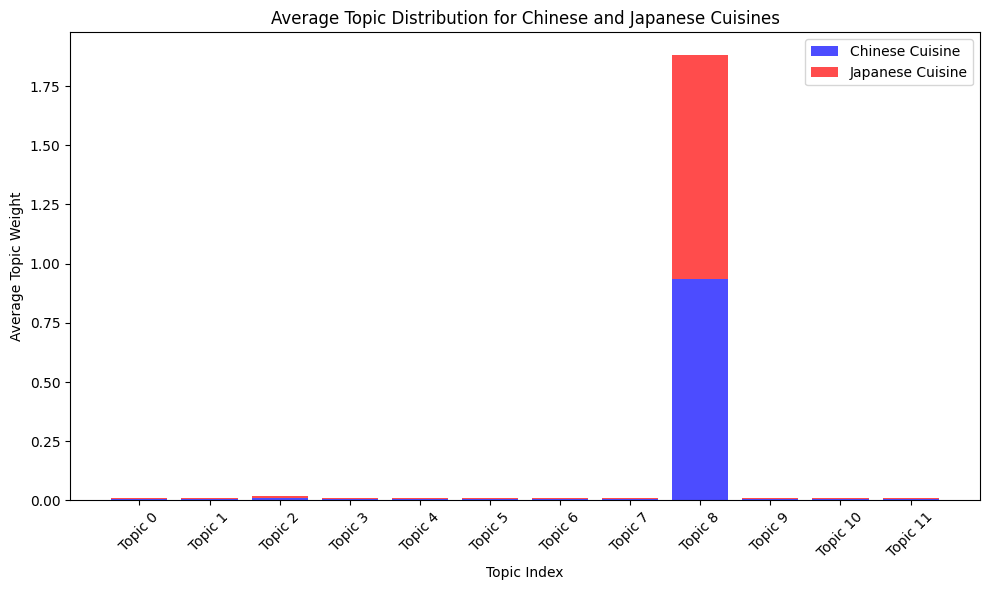

In [24]:
#plot to see
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data for plotting, HARD CODING....
data = {
    'Topic': [f'Topic {i}' for i in range(12)],
    'Chinese_Cuisine': [0.00538, 0.00494, 0.00878, 0.00552, 0.00572, 0.00517, 0.00528, 0.00491, 0.93717, 0.00531, 0.00504, 0.00669],
    'Japanese_Cuisine': [0.00443, 0.00426, 0.00851, 0.00456, 0.00498, 0.00440, 0.00457, 0.00418, 0.94582, 0.00432, 0.00425, 0.00567]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Plotting stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Topics as the x axis
topics = df['Topic']

# Plot bars for Chinese and Japanese cuisines
ax.bar(topics, df['Chinese_Cuisine'], color='blue', label='Chinese Cuisine', alpha=0.7)
ax.bar(topics, df['Japanese_Cuisine'], bottom=df['Chinese_Cuisine'], color='red', label='Japanese Cuisine', alpha=0.7)

# Add labels and title
ax.set_xlabel('Topic Index')
ax.set_ylabel('Average Topic Weight')
ax.set_title('Average Topic Distribution for Chinese and Japanese Cuisines')
ax.legend()

# Rotate topic labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()



In [40]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the JSON file into a DataFrame
with open('/home/ymusic7/metro_restaurants/lda_topics_series.json', 'r') as json_file:
    json_data = json.load(json_file)

# Assuming the JSON data is a list of dictionaries
topics_df = pd.DataFrame(json_data)

# Check the structure of the DataFrame
print(topics_df.head())


             0        1        2        3        4        5        6        7  \
Topic  Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7   

             8        9        10        11  
Topic  Topic 8  Topic 9  Topic 10  Topic 11  


In [49]:

import pandas as pd

topics_df = pd.DataFrame(data)
print(topics_df.head())


     Topic  Chinese_Cuisine  Japanese_Cuisine
0  Topic 0          0.00538           0.00443
1  Topic 1          0.00494           0.00426
2  Topic 2          0.00878           0.00851
3  Topic 3          0.00552           0.00456
4  Topic 4          0.00572           0.00498


In [52]:
import pandas as pd

# Assuming 'topics_df' is already created
topics_df.to_csv('/home/ymusic7/metro_restaurants/topics_df.csv', index=False)



In [45]:
print("Columns in DataFrame:", topics_df.columns)
print("First few rows of DataFrame:", topics_df.head())


Columns in DataFrame: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], dtype='object')
First few rows of DataFrame:              0        1        2        3        4        5        6        7  \
Topic  Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7   

             8        9        10        11  
Topic  Topic 8  Topic 9  Topic 10  Topic 11  


In [15]:
# Convert PySpark DataFrame to a NumPy array for TF-IDF features
tfidf_array = df_tfidf.select("features").rdd.map(lambda x: x[0].toArray()).collect()


Exception in thread "refresh progress" java.lang.OutOfMemoryError: Java heap space
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.status.AppStatusStore.activeStages(AppStatusStore.scala:170)
	at org.apache.spark.ui.ConsoleProgressBar.org$apache$spark$ui$ConsoleProgressBar$$refresh(ConsoleProgressBar.scala:64)
	at org.apache.spark.ui.ConsoleProgressBar$$anon$1.run(ConsoleProgressBar.scala:52)
	at java.base/java.util.TimerThread.mainLoop(Timer.java:556)
	at java.base/java.util.TimerThread.run(Timer.java:506)
24/11/20 07:20:38 ERROR Executor: Exception in task 0.0 in stage 1930.0 (TID 18698)
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:776)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at 

ConnectionRefusedError: [Errno 111] Connection refused